# Edge-Optimized ECG Preprocessing for Arrhythmia Detection


This notebook implements an edge-aware preprocessing pipeline for ECG signals
from the MIT-BIH Arrhythmia Database. The focus is on reducing sampling rate,
memory footprint, and computational complexity to enable deployment on
resource-constrained edge devices.

In [24]:
import numpy as np
import pandas as pd
import wfdb
from scipy.signal import resample
import matplotlib.pyplot as plt

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("wfdb:", wfdb.__version__)
print("All imports successful ✅")

numpy: 1.23.5
pandas: 1.5.3
wfdb: 4.1.2
All imports successful ✅


In [25]:
#raw ECG loading

record = wfdb.rdrecord("mit-bih-arrhythmia-database-1.0.0/100")

signal = record.p_signal[:, 0]   # MLII lead
fs = record.fs

print("Sampling frequency:", fs)

Sampling frequency: 360


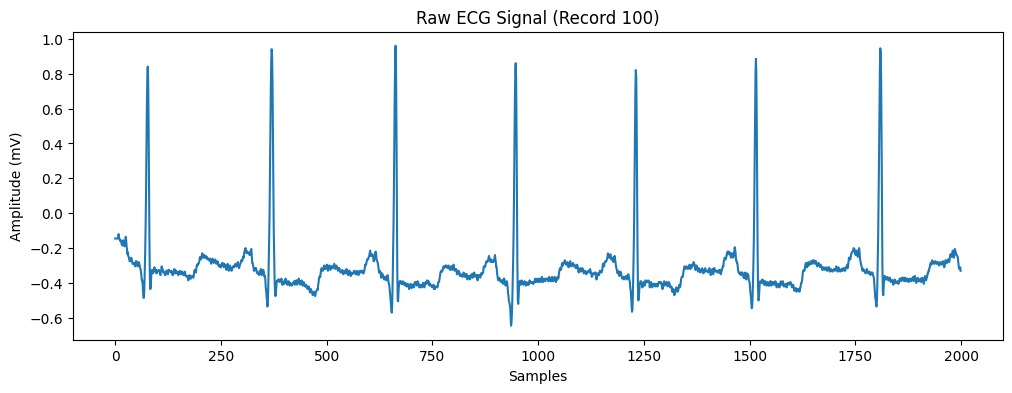

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signal[:2000])
plt.title("Raw ECG Signal (Record 100)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()

## Downsampling for Edge Deployment

The original ECG signal is sampled at 360 Hz, which is suitable for clinical
analysis but computationally expensive for edge devices. To reduce data rate
and memory usage, the signal is downsampled to 180 Hz while preserving the
essential waveform morphology.

In [28]:
from scipy.signal import resample

target_fs = 180  # target sampling frequency for edge devices
num_samples = int(len(signal) * target_fs / fs)

signal_downsampled = resample(signal, num_samples)

print("Original sampling rate:", fs)
print("Downsampled sampling rate:", target_fs)
print("Original samples:", len(signal))
print("Downsampled samples:", len(signal_downsampled))

Original sampling rate: 360
Downsampled sampling rate: 180
Original samples: 650000
Downsampled samples: 325000


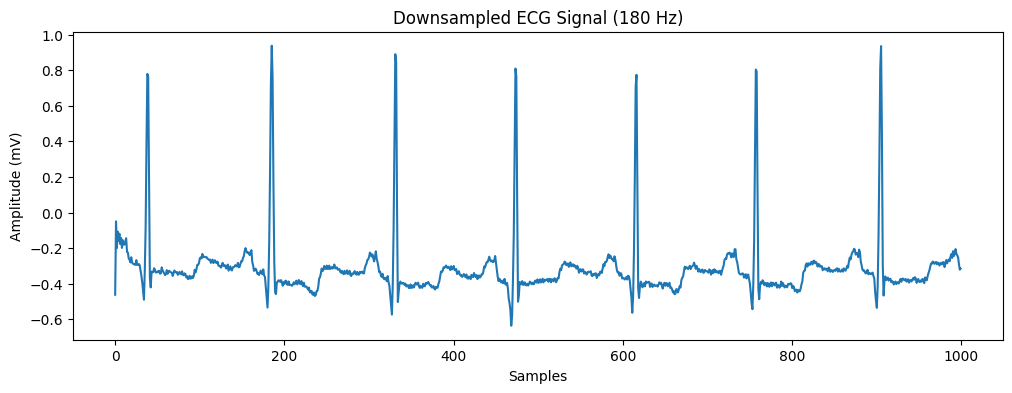

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(signal_downsampled[:1000])
plt.title("Downsampled ECG Signal (180 Hz)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.show()

The downsampled ECG retains the overall P-QRS-T morphology while significantly
reducing the number of samples, making it suitable for real-time processing on
resource-constrained edge devices.

## Amplitude Clipping

Amplitude clipping is applied to suppress extreme outliers caused by motion
artifacts or sensor noise, without using computationally expensive filters.

In [30]:
import numpy as np

clip_limit = np.percentile(np.abs(signal_downsampled), 99)

signal_clipped = np.clip(
    signal_downsampled,
    -clip_limit,
    clip_limit
)

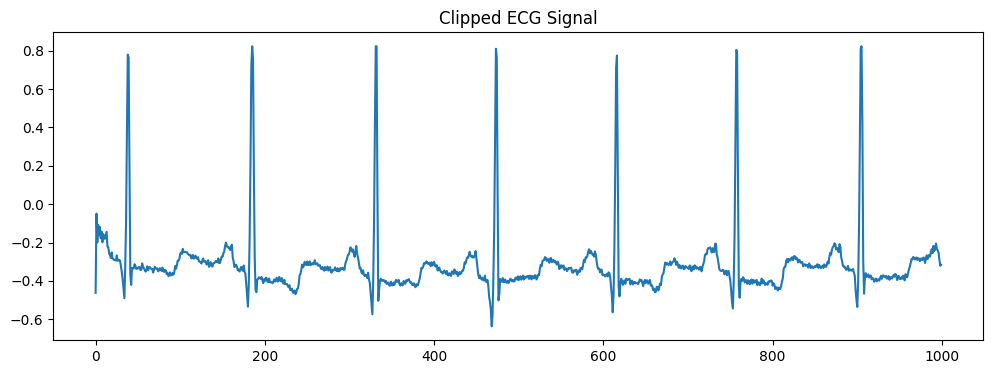

In [31]:
plt.figure(figsize=(12,4))
plt.plot(signal_clipped[:1000])
plt.title("Clipped ECG Signal")
plt.show()

## Quantization for Edge Deployment

Quantization converts the ECG signal into an 8-bit representation, reducing
memory usage and enabling efficient inference on edge devices.

In [32]:
min_val = signal_clipped.min()
max_val = signal_clipped.max()

signal_quantized = np.round(
    (signal_clipped - min_val) / (max_val - min_val) * 255
).astype(np.uint8)

In [33]:
signal_edge_ready = signal_quantized / 255.0

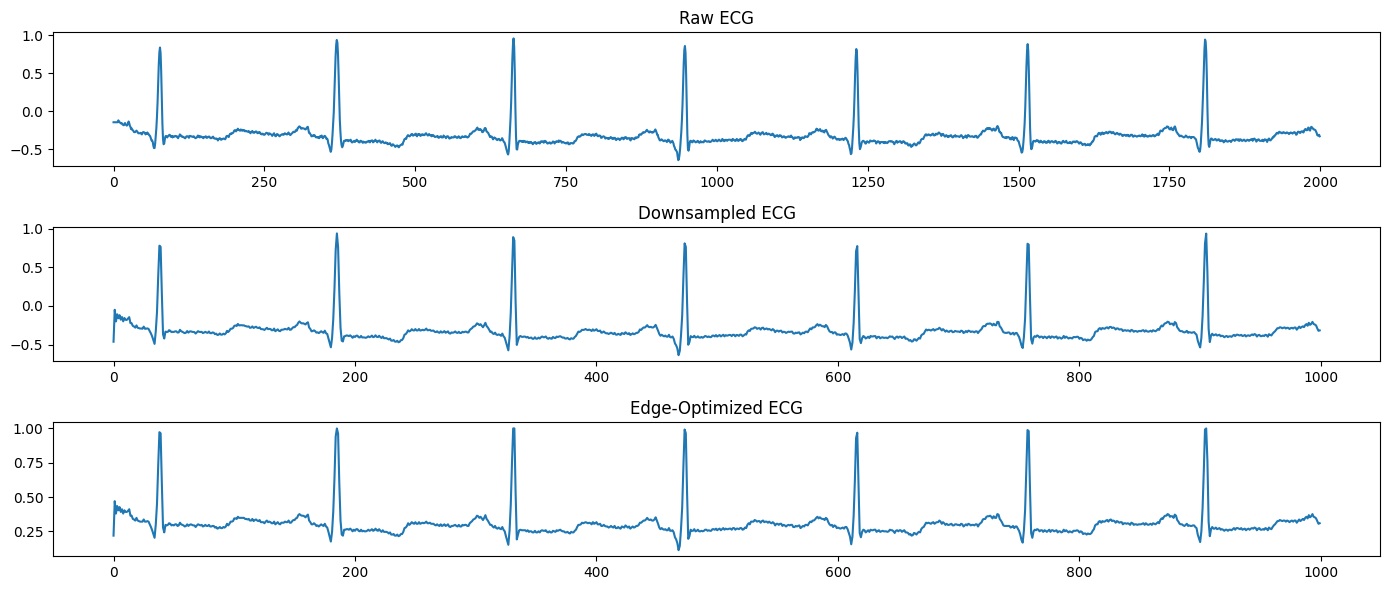

In [34]:
plt.figure(figsize=(14,6))

plt.subplot(3,1,1)
plt.plot(signal[:2000])
plt.title("Raw ECG")

plt.subplot(3,1,2)
plt.plot(signal_downsampled[:1000])
plt.title("Downsampled ECG")

plt.subplot(3,1,3)
plt.plot(signal_edge_ready[:1000])
plt.title("Edge-Optimized ECG")

plt.tight_layout()
plt.show()